### Analyzing/Predicting Sentiment From Amazon Reviews

For this exercise, let's go back to the sentiment analysis we did earlier in the course - specifically, the Amazon reviews dataset.

It's important to start with a clear goal in mind. In this case, we'd like to determine if we can __predict whether a review is positive or negative based on the language in the review.__

We're going to tackle this problem with Spark - so you'll need to apply the principles you've learned thus far in the context of Spark.

Some tips to help you get started:
1. Pyspark always needs to point at a running Spark instance. You can do that using a `SparkContext`.
2. We're still working in batch mode, so you'll need to load an entire file into memory in order to run any models you build.
3. Spark likes to execute models in a pipeline, so remember that when the time comes to set up your model.
4. Spark's machine learning algorithms expect numeric variables.

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import Tokenizer, Word2Vec

# these imports are how we build and manager our data science processes: cleaning data, preparing a model,
# executing the model, and evaluating the model.
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from matplotlib import pyplot as plt
import numpy as np
import functools
%matplotlib inline

In [2]:
# Set constants
DATA_NAME = "reviews_Apps_for_Android_5.json"
APP_NAME = "Sentiment Analysis of Amazon Reviews"
SPARK_URL = "local[*]"
RANDOM_SEED = 141107
TRAINING_DATA_RATIO = 0.8
RF_NUM_TREES = 100
RF_MAX_DEPTH = 2
RF_NUM_BINS = 32

In [3]:
spark = SparkSession.builder.appName(APP_NAME).master(SPARK_URL).getOrCreate()

In [4]:
sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [5]:
android_reviews = sqlContext.read.json(DATA_NAME)

In [6]:
android_reviews.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)



In [7]:
android_reviews.registerTempTable('reviews')
sqlContext.sql("select overall, count(overall) as review_count from reviews group by overall order by overall desc").show()

+-------+------------+
|overall|review_count|
+-------+------------+
|    5.0|      386637|
|    4.0|      158081|
|    3.0|       85121|
|    2.0|       44385|
|    1.0|       78713|
+-------+------------+



In [8]:
# binarize the reviews so over 3 is positive and 3 and below is negative

In [9]:
udf = UserDefinedFunction(lambda x: 1 if x > 3.0 else -1, IntegerType())
android_reviews = android_reviews.withColumn("overall_recode",udf(android_reviews.overall))

In [10]:
android_reviews.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- overall_recode: integer (nullable = true)



In [11]:
plt.rcParams['figure.figsize'] = (10, 6)

statuses = android_reviews.groupBy('overall_recode').count().collect()

categories = [i[0] for i in statuses]
counts = [i[1] for i in statuses]

([<matplotlib.axis.XTick at 0x7f47a44c8a90>,
 <a list of 2 Text xticklabel objects>)

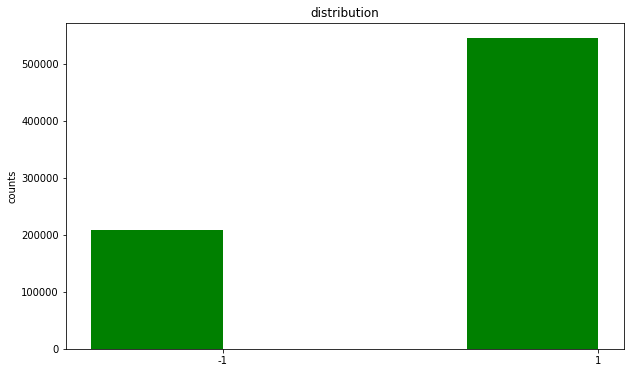

In [12]:
ind = np.array(range(len(categories)))
width = 0.35
plt.bar(ind,counts,width=width,color='g')

plt.ylabel('counts')
plt.title('distribution')
plt.xticks(ind+width/2.,categories)

In [13]:
# encode text into vectors
android_reviews.select('overall','overall_recode','summary','reviewText').show(10)

+-------+--------------+--------------------+--------------------+
|overall|overall_recode|             summary|          reviewText|
+-------+--------------+--------------------+--------------------+
|    3.0|            -1|         Really cute|Loves the song, s...|
|    5.0|             1| 2-year-old loves it|Oh, how my little...|
|    5.0|             1|            Fun game|I found this at a...|
|    5.0|             1|We love our Monkeys!|My 1 year old goe...|
|    5.0|             1|This is my grandd...|There are three d...|
|    5.0|             1|             so cute|THis is just so c...|
|    5.0|             1|           Terrific!|I watch my great ...|
|    5.0|             1| Five Little Monkeys|This app is wild ...|
|    5.0|             1|   love but to quite|love love love th...|
|    5.0|             1|                Cute|Very cute, with a...|
+-------+--------------+--------------------+--------------------+
only showing top 10 rows



In [16]:
# taking summary text, not full reviews
tokenizer = Tokenizer(inputCol='summary',outputCol='tokenized_text').transform(android_reviews)

In [17]:
word2Vec = Word2Vec(vectorSize=100,seed=42,inputCol='tokenized_text',outputCol='w2v_vector',
                    stepSize=.5,windowSize=10,numPartitions=5).fit(tokenizer)
w2vdf = word2Vec.transform(tokenizer)

In [18]:
w2vdf.printSchema()

root
 |-- asin: string (nullable = true)
 |-- helpful: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- unixReviewTime: long (nullable = true)
 |-- overall_recode: integer (nullable = true)
 |-- tokenized_text: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- w2v_vector: vector (nullable = true)



In [19]:
# Build the training indexers/split data/classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="overall_recode", outputCol="indexedLabel").fit(w2vdf)

# now generate the indexed feature vector.
featureIndexer = VectorIndexer(inputCol="w2v_vector", outputCol="indexedFeatures", maxCategories=4).fit(w2vdf)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = w2vdf.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf])

In [20]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

In [21]:
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.26097
Accuracy = 0.73903


In [22]:
# New pipeline but with Naive Bayes instead of RF

In [28]:
from pyspark.mllib.classification import NaiveBayes, NaiveBayesModel
from pyspark.ml.classification import LogisticRegression

In [29]:
# Build the training indexers/split data/classifier
# first we'll generate a labelIndexer
labelIndexer = StringIndexer(inputCol="overall_recode", outputCol="indexedLabel").fit(w2vdf)

# now generate the indexed feature vector.
featureIndexer = VectorIndexer(inputCol="w2v_vector", outputCol="indexedFeatures", maxCategories=4).fit(w2vdf)
    
# Split the data into training and validation sets (30% held out for testing)
(trainingData, testData) = w2vdf.randomSplit([TRAINING_DATA_RATIO, 1 - TRAINING_DATA_RATIO])

# Train an NB model.
# rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=RF_NUM_TREES)
# nb = NaiveBayes(smoothing=1.0,modeltype='binomial')
lr = LogisticRegression(maxIter=10,labelCol="indexedLabel",featuresCol="indexedFeatures")

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, lr])

In [30]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Error = {(1.0 - accuracy):g}")
print(f"Accuracy = {accuracy:g}")

Test Error = 0.270093
Accuracy = 0.729907


In [31]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
f1 = evaluator.evaluate(predictions)
print("f1 score: {}".format(f1))

f1 score: 0.6643380752819172


In [33]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator.evaluate(predictions)
print("Recall: {}".format(recall))

Recall: 0.7299066282117129
